In [11]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt


# Watershed Segmentation usando OpenCV

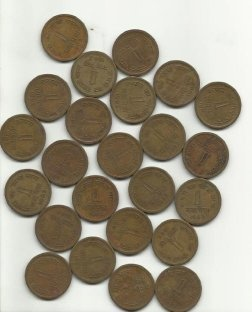

In [12]:
# Plot the image
def imshow(img, ax=None):
	if ax is None:
		ret, encoded = cv2.imencode(".jpg", img)
		display(Image(encoded))
	else:
		ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		ax.axis('off')

#Image loading
img = cv2.imread("../images/water_coins.jpg")
# Show image
imshow(img)


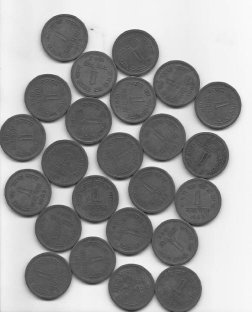

In [13]:
#image grayscale conversion
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)


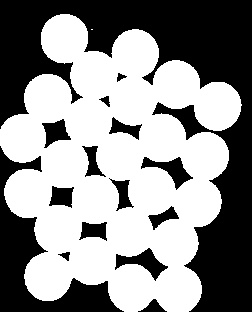

In [14]:
#Threshold Processing
ret, bin_img = cv2.threshold(gray,
							0, 255, 
							cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
imshow(bin_img)

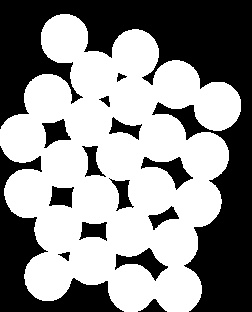

In [15]:
# noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, 
						cv2.MORPH_OPEN,
						kernel,
						iterations=2)
imshow(bin_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..23.968996].


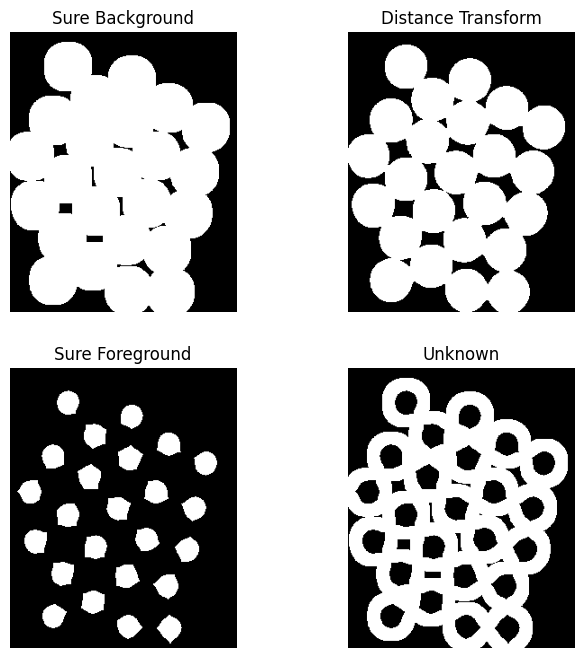

In [16]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sure background area
sure_bg = cv2.dilate(bin_img, kernel, iterations=3)
imshow(sure_bg, axes[0,0])
axes[0, 0].set_title('Sure Background')

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)
imshow(dist, axes[0,1])
axes[0, 1].set_title('Distance Transform')

#foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8) 
imshow(sure_fg, axes[1,0])
axes[1, 0].set_title('Sure Foreground')

# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
imshow(unknown, axes[1,1])
axes[1, 1].set_title('Unknown')

plt.show()


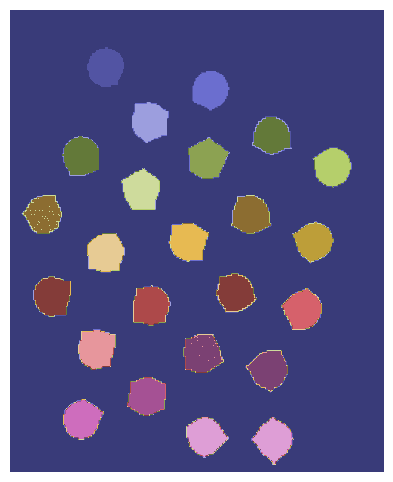

In [17]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

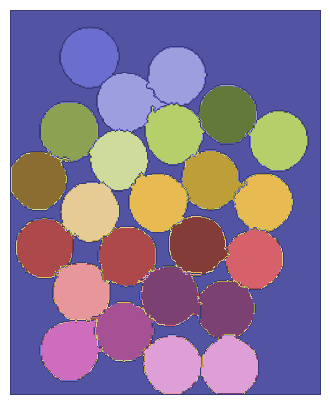

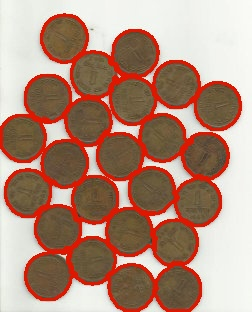

In [18]:
# watershed Algorithm
markers = cv2.watershed(img, markers)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()


labels = np.unique(markers)

coins = []
for label in labels[2:]: 

# Create a binary image in which only the area of the label is in the foreground 
#and the rest of the image is in the background 
	target = np.where(markers == label, 255, 0).astype(np.uint8)

# Perform contour extraction on the created binary image
	contours, hierarchy = cv2.findContours(
		target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
	)
	coins.append(contours[0])

# Draw the outline
img = cv2.drawContours(img, coins, -1, color=(0, 23, 223), thickness=2)
imshow(img)